# Challenge Data ENS : Return Forecasting of Cryptocurrency Clusters (par Napoleon X)

## Introduction

Ce projet s’inscrit dans le cadre du challenge **« Return Forecasting of Cryptocurrency Clusters »**, proposé sur **Challenge Data ENS** par **Napoleon X**, une société d’investissement quantitatif spécialisée dans les crypto-actifs.
L’objectif est de **prédire le rendement moyen d’un cluster de cryptomonnaies relativement au Bitcoin** durant la dernière heure d’une journée, à partir des rendements observés pendant les 23 premières heures.

---

## 1. Packages et paramètres

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import pickle
import missingno as msno

# paramètres de style pour les graphiques
plt.style.use("dark_background")

plt.rcParams.update({
    "grid.color": "#444444",
    "grid.alpha": 0.8,
    "grid.linestyle": "--", 
})

---

## 2. Data

Les clusters évoluent dans le temps et sont **mis à jour chaque semaine**. Chaque clustering est valide pour **trois semaines (21 jours)**, générant ainsi 21 échantillons par cluster.

Un **échantillon** correspond à un couple *{cluster, jour}* et contient les **rendements horaires des 23 premières heures** pour chacun des actifs du cluster, exprimés **relativement au Bitcoin**. 

Deux variables additionnelles, **md** et **bc**, sont fournies mais leur nature reste confidentielle.

Les actifs et clusters sont **anonymisés**, et les prix exprimés en Bitcoin :

* **rendement positif** → surperformance par rapport à Bitcoin
* **rendement négatif** → sous-performance.

### 2.1 Importation des données

In [11]:
x_train = pd.read_csv('input/input_train__fppJZ22.csv')
y_train = pd.read_csv('input/y_train_CGZ7jXu.csv')
x_test = pd.read_csv('input/input_test__2scdXsn.csv')

with open("input/adjacency_matrices_pgWTvf5.pkl", "rb") as file:
    adj = pickle.load(file)
    
print("Taille de x_train :", x_train.shape)
print("Taille de y_train :", y_train.shape)

display(x_train.head(), y_train.head())

Taille de x_train : (491038, 29)
Taille de y_train : (30494, 2)


,id,cluster,day,asset,md,bc,ret_1,ret_2,ret_3,ret_4,...,ret_14,ret_15,ret_16,ret_17,ret_18,ret_19,ret_20,ret_21,ret_22,ret_23
0,0,0,17,10,-5.734573,0.125855,-0.002060,0.005848,-0.002736,-0.005487,...,NaN,-0.000339,0.001018,-0.002372,-0.000340,-0.000680,-0.007140,0.006849,0.002041,-0.001697
1,1,0,0,13,-5.813696,0.418711,-0.042280,-0.009460,-0.005173,-0.006000,...,0.004107,-0.005726,0.006993,-0.003268,0.015574,-0.010492,0.004486,0.011368,0.001606,0.000401
2,2,0,20,12,-5.814399,0.500111,0.003665,-0.010841,0.007557,0.004981,...,-0.000113,-0.000170,-0.002833,-0.007442,-0.001832,-0.005677,-0.007093,0.001626,0.004349,-0.004677
3,3,0,19,12,-5.814399,0.500111,-0.018364,0.003789,0.011795,0.016029,...,0.005604,-0.009794,-0.001023,-0.002959,0.002568,-0.005579,0.001317,-0.010005,0.004677,-0.004196
4,4,0,18,12,-5.814399,0.500111,-0.001589,0.011711,-0.010507,-0.002555,...,0.002530,-0.018505,-0.010855,0.002022,0.001211,-0.002648,0.001559,-0.001153,0.000635,0.001961


,sample_id,target
0,0,0.000301
1,1,-0.011966
2,2,-0.011395
3,3,0.000664
4,4,0.002852


### 2.2 Structure des données

Les **données d’entrée (`x_train`)** comprennent 29 colonnes :

* **id**, **cluster**, **day**, **asset**, **md**, **bc**
* **ret_1 à ret_23** : rendements horaires relatifs au Bitcoin sur les 23 premières heures de la journée.

Les **données de sortie (`y_train`)** contiennent :

* **sample_id** : identifiant unique d’un échantillon *{cluster, jour}*
* **target** : rendement moyen du cluster relativement au Bitcoin pendant la 24ᵉ heure.

L’identifiant est calculé comme :

> `sample_id = cluster × 21 + day`

Le jeu de données inclut **2 091 clusters**, soit environ **43 600 échantillons théoriques**. Après nettoyage, on obtient **30 494 échantillons d’entraînement (≈70 %)** et **13 133 échantillons de test (≈30 %)**, les échantillons de test correspondant à des **périodes ultérieures** pour assurer une séparation temporelle réaliste.

### 2.3 Valeurs manquantes

#### 2.3.1 Analyse des valeurs manquantes

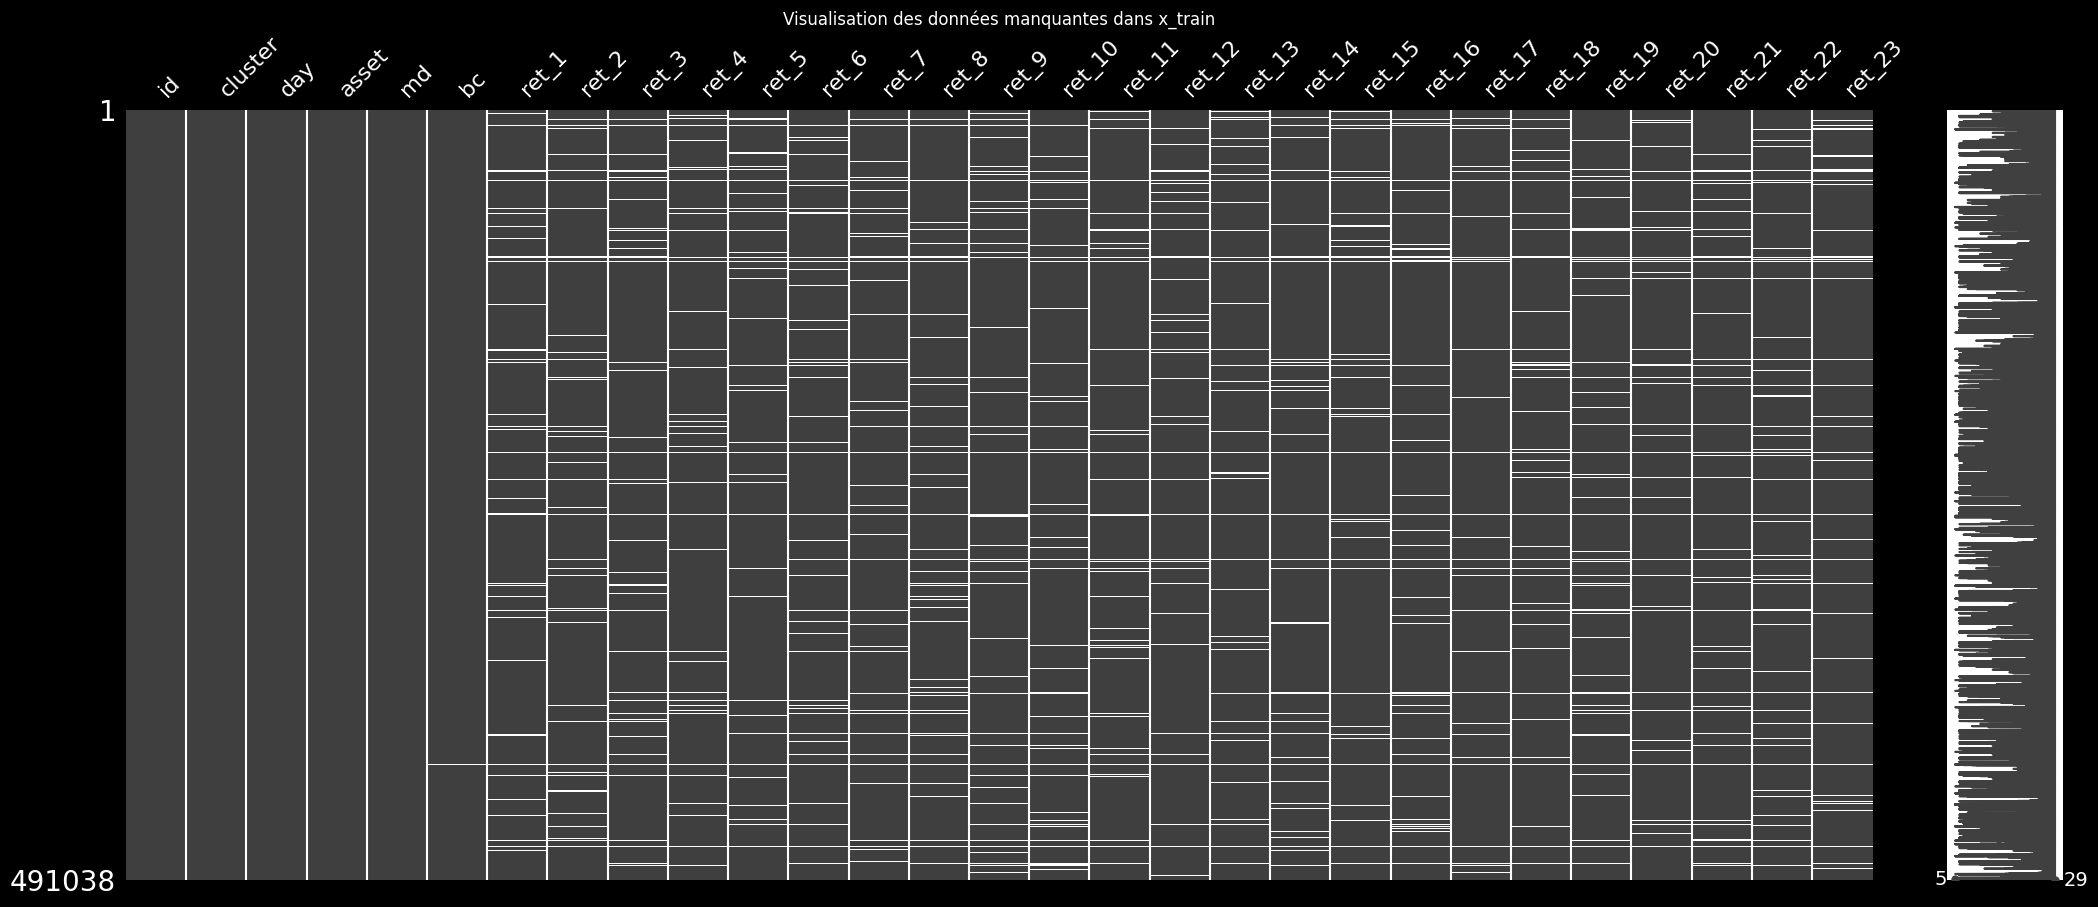

Résumé des données manquantes dans x_train :
         count   percent
ret_20   28373  5.778168
ret_19   28310  5.765338
ret_4    28007  5.703632
ret_21   27984  5.698948
ret_22   27890  5.679805
ret_6    27556  5.611786
ret_7    26963  5.491021
ret_18   26867  5.471471
ret_5    26834  5.464750
ret_23   26706  5.438683
ret_10   26644  5.426057
ret_3    26422  5.380846
ret_11   25931  5.280854
ret_8    25770  5.248066
ret_2    25652  5.224036
ret_12   25367  5.165995
ret_9    25311  5.154591
ret_13   24933  5.077611
ret_14   24812  5.052969
ret_16   24348  4.958476
ret_15   24019  4.891475
ret_17   23977  4.882921
ret_1    23869  4.860927
bc        1092  0.222386
cluster      0  0.000000
md           0  0.000000
asset        0  0.000000
day          0  0.000000
id           0  0.000000


In [12]:
msno.matrix(x_train)
plt.title("Visualisation des données manquantes dans x_train")
plt.show()

print("Résumé des données manquantes dans x_train :")
missing_summary = x_train.isnull().sum().to_frame(name='count')
missing_summary['percent'] = (missing_summary['count'] / len(x_train)) * 100
print(missing_summary.sort_values(by='percent', ascending=False))

**Analyse des valeurs manquantes**

* Les valeurs manquantes de la feature confidentielle **bc** sont relativement peu nombreuses et ainsi facilement traitables, nous allons remplacer les valeurs manquantes par **la médiane des valeurs du même cluster et du même jour**, afin de garder des données cohérentes **sans créer de biais.**

* Les valeurs manquantes des autres features de rendement **ret_1 à ret_23** sont beaucoup plus nombreuses. Pour ne pas perdre d’information et préserver la structure des clusters, elles seront imputées par **la moyenne des rendements des autres actifs du même cluster et du même jour.** Cette méthode permet de **conserver la dynamique intra-cluster sans introduire de biais.**

#### 2.3.2 Traitement des valeurs manquantes dans x_train

**Technique :**

* On commence par calculer, dans x_train, les moyennes ou médianes pour chaque groupe défini par cluster et day.

* Ensuite, on effectue un merge entre x_train et ces statistiques afin d’ajouter temporairement une colonne contenant la valeur moyenne ou médiane correspondant à chaque ligne du même groupe.

* Cette colonne sert à remplir (fillna) les valeurs manquantes directement dans x_train.

* Une fois les valeurs manquantes remplacées, la colonne ajoutée est supprimée pour retrouver la structure initiale du jeu de données.


In [ ]:
print("--- NA pour x_train avant traitement ---")
print(x_train.isnull().sum())

# bc
bc_global_median = x_train['bc'].median()
bc_cluster_day_median = x_train.groupby(['cluster', 'day'])['bc'].median().reset_index()

# merge pour ajouter la médiane locale à x_train
x_train = x_train.merge(bc_cluster_day_median, on=['cluster', 'day'], how='left', suffixes=('', '_median'))
x_train['bc'] = x_train['bc'].fillna(x_train['bc_median'])
x_train['bc'] = x_train['bc'].fillna(bc_global_median)
x_train = x_train.drop(columns='bc_median')

# ret_1 à ret_23
ret_cols = [f'ret_{i}' for i in range(1, 24)]
ret_cluster_day_mean = x_train.groupby(['cluster', 'day'])[ret_cols].mean().reset_index()

# merge pour ajouter les moyennes locales à x_train
x_train = x_train.merge(ret_cluster_day_mean, on=['cluster', 'day'], how='left', suffixes=('', '_mean'))

for col in ret_cols:
    x_train[col] = x_train[col].fillna(x_train[f'{col}_mean'])
    x_train[col] = x_train[col].fillna(x_train[col].mean())
    x_train = x_train.drop(columns=[f'{col}_mean'])

print("--- NA pour x_train après traitement ---")
print(x_train.isnull().sum())


#### 2.3.3 Traitement des valeurs manquantes dans x_test

Pour garantir que le modèle fonctionne correctement sur les données de test, il est important de **ne pas recalculer les statistiques (médiane ou moyenne) à partir de x_test**, mais d’utiliser uniquement celles calculées sur **x_train.**  

Cette précaution permet d’éviter le **data leakage**, c’est-à-dire la fuite d’informations provenant du futur ou de l’échantillon de test vers l’entraînement. Si on utilisait x_test pour remplir ses propres valeurs manquantes, le modèle pourrait bénéficier de données qu’il n’aurait pas connues dans un scénario réel de prédiction, ce qui biaiserait les résultats.

Concrètement :

* Pour la variable `bc`, les valeurs manquantes dans x_test sont remplacées par la **médiane du même cluster et du même jour calculée sur x_train**. Si le groupe n’existe pas dans x_train, on utilise la **médiane globale de x_train**.

* Pour les rendements horaires `ret_1` à `ret_23`, les NA sont remplacés par la **moyenne des autres actifs du même cluster et jour dans x_train**, ou par la **moyenne globale de x_train** si le groupe est absent.

Ainsi, x_test reste **cohérent avec x_train**, toutes les valeurs manquantes sont traitées, et le modèle ne bénéficie d’aucune information provenant du futur ou des données de test.

In [ ]:
print("--- NA pour x_test avant traitement ---")
print(x_test.isnull().sum())

# bc
bc_global_median = x_train['bc'].median()
bc_cluster_day_median = x_train.groupby(['cluster', 'day'])['bc'].median().reset_index()

# merge pour ajouter la médiane locale à x_test
x_test = x_test.merge(bc_cluster_day_median, on=['cluster', 'day'], how='left', suffixes=('', '_median'))
x_test['bc'] = x_test['bc'].fillna(x_test['bc_median'])
x_test['bc'] = x_test['bc'].fillna(bc_global_median)
x_test = x_test.drop(columns='bc_median')

# ret_1 à ret_23
ret_cols = [f'ret_{i}' for i in range(1, 24)]
ret_cluster_day_mean = x_train.groupby(['cluster', 'day'])[ret_cols].mean().reset_index()

# merge pour ajouter les moyennes locales à x_test
x_test = x_test.merge(ret_cluster_day_mean, on=['cluster', 'day'], how='left', suffixes=('', '_mean'))

for col in ret_cols:
    x_test[col] = x_test[col].fillna(x_test[f'{col}_mean'])
    x_test[col] = x_test[col].fillna(x_train[col].mean())  # fallback global
    x_test = x_test.drop(columns=[f'{col}_mean'])

print("--- NA pour x_test après traitement ---")
print(x_test.isnull().sum())

### 2.4 Statistiques descriptives

#### 2.4.1 Distribution

Nombre de clusters dans l'ensemble d'entraînement : 1464


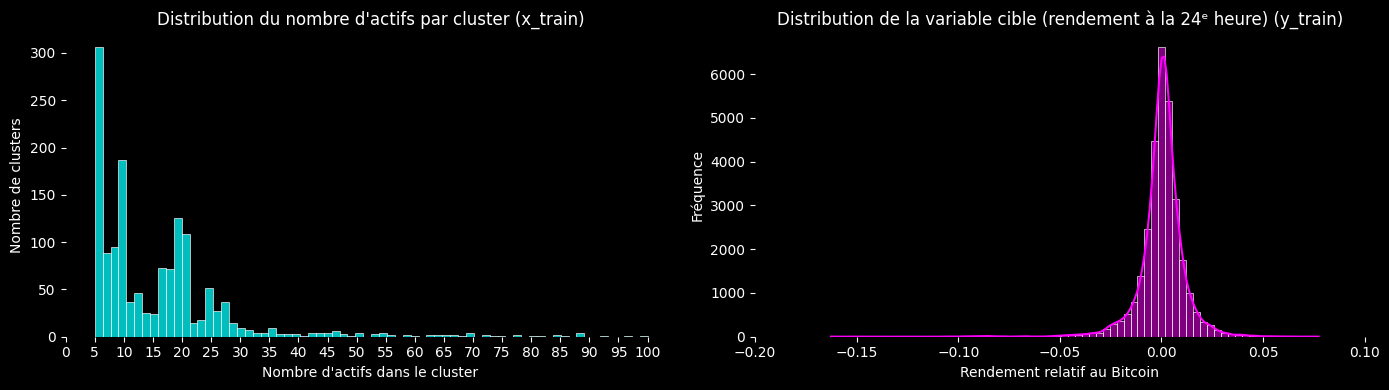

In [26]:
n_clusters = x_train['cluster'].nunique()
print(f"Nombre de clusters dans l'ensemble d'entraînement : {n_clusters}")

assets_per_cluster = x_train.groupby('cluster')['asset'].nunique()

fig, axes = plt.subplots(1, 2, figsize=(14, 4))  # 1 ligne, 2 colonnes

sns.histplot(assets_per_cluster, bins=70, ax=axes[0], color="#00FFFF")
axes[0].set_title("Distribution du nombre d'actifs par cluster (x_train)")
axes[0].set_xlabel("Nombre d'actifs dans le cluster")
axes[0].set_ylabel("Nombre de clusters")
axes[0].set_xticks(range(0, assets_per_cluster.max()+1, 5))
for spine in axes[0].spines.values():
    spine.set_visible(False)

sns.histplot(y_train['target'], bins=70, kde=True, ax=axes[1], color="#FF00FF")
axes[1].set_title("Distribution de la variable cible (rendement à la 24ᵉ heure) (y_train)")
axes[1].set_xlabel("Rendement relatif au Bitcoin")
axes[1].set_ylabel("Fréquence")
axes[1].set_xticks(np.arange(-0.2, 0.15, 0.05))
for spine in axes[1].spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()


**Analyse**

* blabla

#### 2.4.2 Corrélation des features 

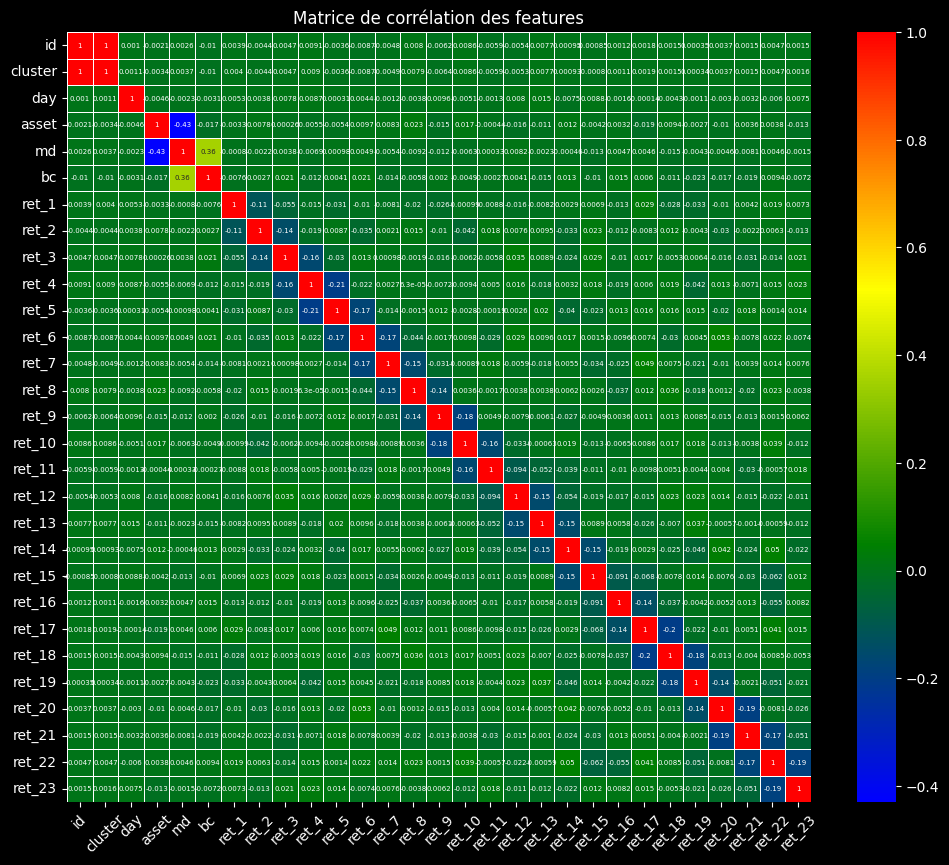

In [32]:
# Matirce de corrélation colormap
colors = ["blue", "green", "yellow", "red"]  # bleu -> vert pour négatif, jaune -> rouge pour positif
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

plt.figure(figsize = (12,10))
plt.title("Matrice de corrélation des features")
sns.heatmap(x_train.corr(), annot = True, annot_kws={"size": 5}, linewidths=.5, cmap=custom_cmap)
plt.xticks(rotation=45)
plt.show()

**Analyse de la corrélation des features**

* On observe sur cette heatmap de corrélation que les variables inconnues **md et bc** présentent une **corrélation positive** modérée (0.36), suggérant qu’elles **évoluent généralement dans le même sens.** 

* De plus, les variables de rendement **(ret_t)** sont légèrement **corrélées négativement entre heures consécutives (t et t+1)**, ce qui signifie **qu’une hausse du rendement à une heure donnée tend à être suivie d’une légère baisse l’heure suivante**, traduisant un effet de correction ou de retour à la moyenne, phénomène fréquement observé sur le marché des cryptomonnaies à l'échelle intraday.

### 2.5 Transformation du Dataset

Nous créons la colonne sample_id pour que nos datasets d'entraînements correspondent.

* La formule utilisée :`sample_id = cluster × 21 + day`

L’agrégation consiste ici à regrouper tous les actifs d’un même cluster et d’un même jour (sous un identifiant unique **sample_id**), puis à calculer la **moyenne de chaquen rendement horaires** (ret_1 à ret_23) pour obtenir une seule ligne représentative par **cluster × jour**.

Ex :

| cluster | day | asset | ret_1 | ret_2 | ret_3 | ... |
| ----- | ----- | ----- | ----- | ----- | ----- | ------|
| 0 | 1 | BTC   | 0.01  | 0.02  | 0.03  | ... |
| 0 | 1 | ETH   | 0.03  | 0.01  | 0.05  | ... |

devient

| sample_id | ret_1 | ret_2 | ret_3 | ... |
| --- | ----- | ----- | ----- | ------|
 1   | 0.02  | 0.015 | 0.04  | ... |

In [35]:
x_train['sample_id'] = x_train['cluster'] * 21 + x_train['day']
x_test['sample_id'] = x_test['cluster'] * 21 + x_test['day']

agg_cols = [f'ret_{i}' for i in range(1, 24)]
x_agg = x_train.groupby('sample_id')[agg_cols].mean().reset_index()

x_agg_extra = x_train.groupby('sample_id').agg({
    'md': 'mean',
    'bc': 'mean'
}).reset_index()
x_agg = x_agg.merge(x_agg_extra, on='sample_id')

display(x_agg.head(), y_train.head())

,sample_id,ret_1,ret_2,ret_3,ret_4,ret_5,ret_6,ret_7,ret_8,ret_9,...,ret_16,ret_17,ret_18,ret_19,ret_20,ret_21,ret_22,ret_23,md,bc
0,0,-0.003180,0.001928,0.002466,-0.010499,0.001530,-0.003849,-0.006318,-0.017592,0.002282,...,0.005674,-0.005571,0.006949,0.005116,0.003103,0.009894,0.002359,0.006052,-5.70555,0.599596
1,1,0.013303,0.001179,0.001234,-0.013514,0.014452,0.007980,-0.005909,0.003051,0.001218,...,0.013930,0.006389,0.003227,0.005479,-0.021580,-0.011090,0.005877,0.001482,-5.70555,0.599596
2,2,-0.012115,0.023476,0.010832,0.004019,-0.000939,-0.015029,-0.003969,0.007315,0.011207,...,-0.012736,-0.008211,0.009511,0.001003,-0.012755,-0.020219,-0.011961,0.009295,-5.70555,0.599596
3,3,-0.008271,0.007669,-0.002567,-0.001642,0.000680,0.021091,-0.002882,-0.015067,0.004542,...,0.013038,0.006508,0.000776,-0.012990,-0.014617,-0.011488,0.004350,0.018642,-5.70555,0.599596
4,4,0.011887,0.001898,-0.010022,-0.013176,0.003421,0.008563,0.002711,0.000798,0.001599,...,0.004875,-0.004420,0.004123,0.019168,-0.001895,-0.001574,0.000908,0.005075,-5.70555,0.599596


,sample_id,target
0,0,0.000301
1,1,-0.011966
2,2,-0.011395
3,3,0.000664
4,4,0.002852


# Explication Train / Test, WS et OOS

Le modèle est entraîné sur **x_train** et **y_train**, qui constituent le **Within-Sample (WS)**, c’est-à-dire les données utilisées pour ajuster les paramètres et apprendre les éventuels patterns. 

On réserve **x_test** comme **Out-Of-Sample (OOS)**, un jeu de données jamais vu par le modèle, pour évaluer sa capacité de généralisation. 

Les performances sur WS servent à contrôler l’apprentissage et à ajuster les hyperparamètres, tandis que les prédictions sur OOS permettent de mesurer la robustesse du modèle sur de nouvelles observations, sans risque de **data leakage**.
